In [49]:
# requires Python 2 #

In [50]:
# READ DATA OnlineRetail.xlsx

import pandas as pd
dfs = pd.read_excel('C:\Users\kumarsa\Desktop\Sudodesktop\R&C DTS\OnlineRetail.xlsx', sheet_name='OnlineRetail', index = 'InvoiceDate')

In [51]:
# Meta data
#exploring the unique values

print "Total Number of Interactions #", dfs['InvoiceNo'].count()
print "Number of Unique Interactions #", dfs['InvoiceNo'].nunique()
print "Number of Unique products bought #",dfs['StockCode'].nunique()
print "Number of Unique customers #", dfs['CustomerID'].nunique()
print "Percentage of NA customers %", round(dfs['CustomerID'].isnull().sum() * 100 / len(dfs),2)
print 'Number of countries #',dfs['Country'].nunique()

Total Number of Interactions # 541909
Number of Unique Interactions # 25900
Number of Unique products bought # 4070
Number of Unique customers # 4372
Percentage of NA customers % 24.0
Number of countries # 38


In [52]:
# Cancelled invoices
# Few InvoiceNo start with the letter "c" = cancelled.

cancelled_orders = dfs[dfs['InvoiceNo'].astype(str).str.contains('C')]
cancelled_orders.head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country  
141 2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154 2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235 2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237 2010-12-01 10:24:00       0.29     17548.0  United Kingdom

In [53]:
#check how many rows our dataframe of cancelled orders contain

total_orders = dfs['InvoiceNo'].nunique()
cancelled_number = len(cancelled_orders)
print 'Number of Canceled Orders #',cancelled_number

Number of Canceled Orders # 9288


In [54]:
#remove canceled orders

dfs = dfs[dfs['Quantity']>0]
dfs.shape

(531285, 8)

In [55]:
#remove rows where customerID is NA

dfs.dropna(subset=['CustomerID'],how='all',inplace=True)
dfs.shape

(397924, 8)

In [56]:
#Add a new column AmountSpend: Multiplying Quantity and UnitPrice columns

#dfs['AmountSpend'] = dfs['Quantity']*dfs['UnitPrice']

In [57]:
## Keeping relevant coluns from the Database

matrix_setup = dfs[['StockCode','CustomerID','Quantity','InvoiceDate']]
matrix_setup.shape

(397924, 4)

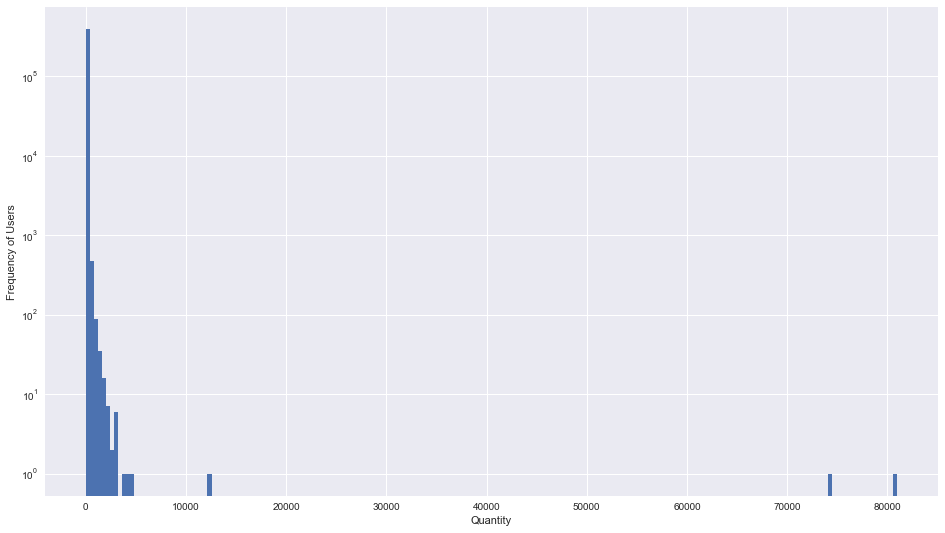

In [58]:
#plotting the amount spend

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]

import seaborn as sns
sns.set()
plt.hist(matrix_setup['Quantity'],bins=200, log=True)
plt.xlabel('Quantity')
plt.ylabel('Frequency of Users')
plt.show()

In [59]:
# removing outliers

matrix_setup = matrix_setup[(matrix_setup['Quantity'] < 5000)]

In [60]:
# Taking Mean of Amount Spend, adding all the similar transactions and then taking the mean
# Similar Transactions is when same User buys the same Item

import numpy as np
#matrix_setup['Mean_amount'] = matrix_setup.groupby(['StockCode','CustomerID'])['AmountSpend'].transform(np.mean)

In [61]:
# DataFrame.drop_duplicates Interactions: where User and Item repeat
# As mean has been already taken in above step

#matrix_toGO = matrix_setup.drop_duplicates(subset = ['StockCode','CustomerID'], keep = 'first') 

In [62]:
lower_bound = min(matrix_setup['Quantity'])
upper_bound = max(matrix_setup['Quantity'])
print lower_bound
print upper_bound

1
4800


In [63]:
# Normalized data [0,1] using min-max approach 

matrix_setup['Norm_Quantity']= (matrix_setup['Quantity'] -lower_bound)/(upper_bound - lower_bound)

In [64]:

lower_bound = min(matrix_setup['Norm_Quantity'])
upper_bound = max(matrix_setup['Norm_Quantity'])
print lower_bound
print upper_bound

0.0
1.0


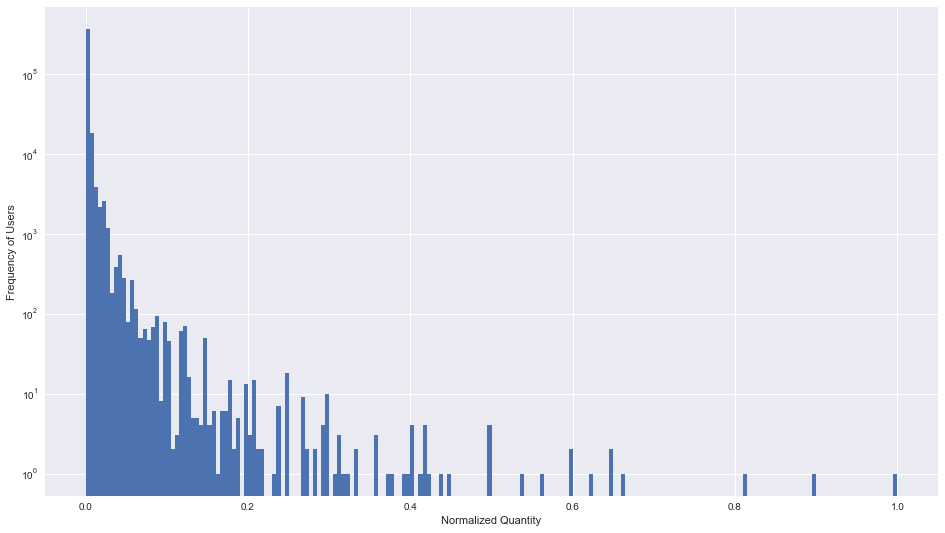

In [65]:
# Plotting Normalized Mean Amount Spend by Users 
plt.rcParams["figure.figsize"] = [16,9]
sns.set()
plt.hist(matrix_setup['Norm_Quantity'],bins=200, log=True)
plt.xlabel('Normalized Quantity')
plt.ylabel('Frequency of Users')
plt.show()

In [66]:
percentage_outliers =(float(matrix_setup[matrix_setup['Norm_Quantity'] > 0.4].count()[0])/(matrix_setup[matrix_setup['Norm_Quantity'] <= 0.4].count()[0]))*100
print 'Percentage of Outliers',percentage_outliers, '%'

Percentage of Outliers 0.006785726851875123 %


In [67]:
# Removing Long Tail Outliers
dfx=matrix_setup[matrix_setup['Norm_Quantity'] <= 0.4]

In [68]:
# keeping Normalized  amount above Zero
dfx.loc[dfx['Norm_Quantity'] == 0, 'Norm_Quantity'] = 0.000001

In [69]:
# Final min-max of data or Upper - Lower bound
lower_bound = min(dfx['Norm_Quantity'])
upper_bound = max(dfx['Norm_Quantity'])
print lower_bound
print upper_bound

1e-06
0.39570743905


In [70]:
#UNIQUE Values 
#exploring the unique values of each attribute

print("Number of products bought: ",dfx['StockCode'].nunique())
print("Number of customers:", dfx['CustomerID'].nunique() )

('Number of products bought: ', 3664)
('Number of customers:', 4336)


In [71]:
# Importing all packages for Latent factor modeling
from surprise import SVD,NMF,SVDpp,evaluate
from surprise.dataset import Dataset
from surprise import Reader

In [72]:
#define the reader  with  upper and lower bounds , also now we are predicting Normalized Total Amount column
reader_x = Reader(rating_scale = (lower_bound,upper_bound))

In [73]:
# for 40:60 distribution of the dataset
# find the dataframe index number which marks 40 percent of dataset
mark_40 = (dfx.shape[0]/100)*40
mark_40

159120

In [74]:
# refereshing the index of dataset. This is required because after deletion of few records, index has missing entities
dfx = dfx.reset_index(drop=True)

In [75]:
# splitting the Dataset  for compairing how Training and Test Amount are distributed
# The comparison can be seen in below two cells, the histogram plots
new_dfx_40 = dfx[0:mark_40]
new_dfx_60 = dfx[mark_40+1:]

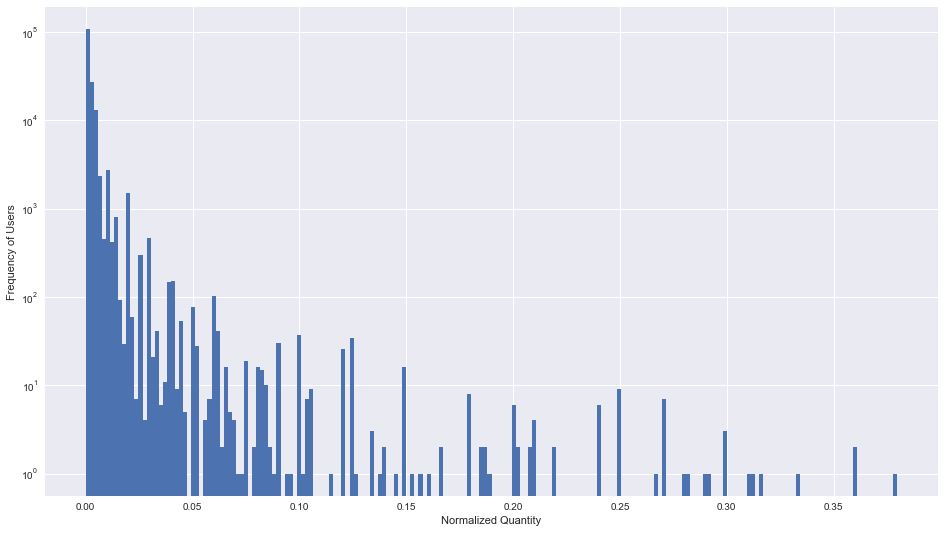

In [76]:
# Training Data plot
sns.set()
plt.hist(new_dfx_40['Norm_Quantity'],bins=200, log=True)
plt.xlabel('Normalized Quantity')
plt.ylabel('Frequency of Users')
plt.show()

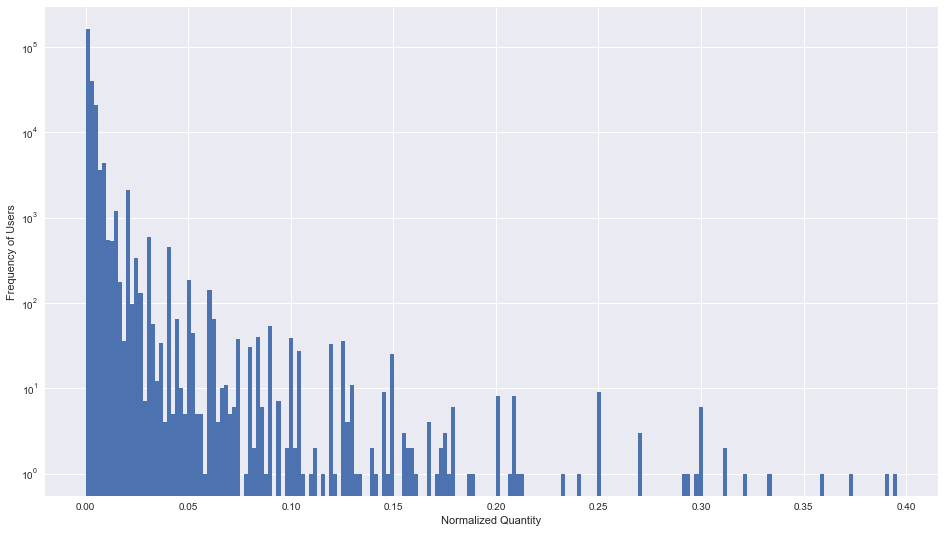

In [77]:
# Test Data plot
sns.set()
plt.hist(new_dfx_60['Norm_Quantity'],bins=200, log=True)
plt.xlabel('Normalized Quantity')
plt.ylabel('Frequency of Users')
plt.show()

In [78]:
# Reading the Data
data = Dataset.load_from_df(df=dfx[['CustomerID','StockCode','Norm_Quantity']],reader=reader_x)

In [79]:
# Splitting the dataset based on Timestamp for Traing and Testing
dfx_40 = data.raw_ratings[0:mark_40]
test_60 = data.raw_ratings[mark_40+1:]
len(dfx_40)

159120

In [80]:
print (data.raw_ratings[0][2] - data.df['Norm_Quantity'][0])

0.0


In [81]:
# Choosing the Model
# Setting up the Model  using best hyper parameters 
# GridSearch has been performed to get these hyperparameter setting: best RMSE
#param_grid = {'n_factors':[2,5,50],'n_epochs': [5,10,50], 'lr_all': [0.1,0.01,0.001],'reg_all': [0.1,0.01,0.001]}
#grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=1)

algo = SVD(lr_all=0.01, reg_all= 0.1, n_factors=2, n_epochs=50)

In [82]:
#creating the traingset afer
trainset = data.construct_trainset(dfx_40)

#creating the testset
testset = data.construct_testset(test_60)

In [83]:
# Train the algorithm on the trainset, and predict ratings for the testset

# check out time
import time
start_time = time.time()
algo.fit(trainset)
print("---%s Time required for Traing the Model in seconds-----" % (time.time() - start_time))



---3.54200005531 Time required for Traing the Model in seconds-----


In [84]:
# Predictions
start_time = time.time()

predictions = algo.test(testset)
print("---%s Time required for Prediction in seconds----" % (time.time() - start_time))

---1.98000001907 Time required for Prediction in seconds----


In [85]:
# Then compute RMSE,MAE

from surprise import accuracy
print 'RMSE over test set ', accuracy.rmse(predictions)
print 'MAE over test set ',accuracy.mae(predictions)

RMSE over test set RMSE: 0.0062
 0.006204975054631326
MAE over test set MAE:  0.0020
 0.0020021459067132126


In [86]:
# List of Test Amount
test_list = []
for i in testset:
    test_list.append(i[-1])

In [87]:
# List of Predicted Amount
prediction_list = []
for i in predictions:
    prediction_list.append(i[3])

Text(0,0.5,u'Test')

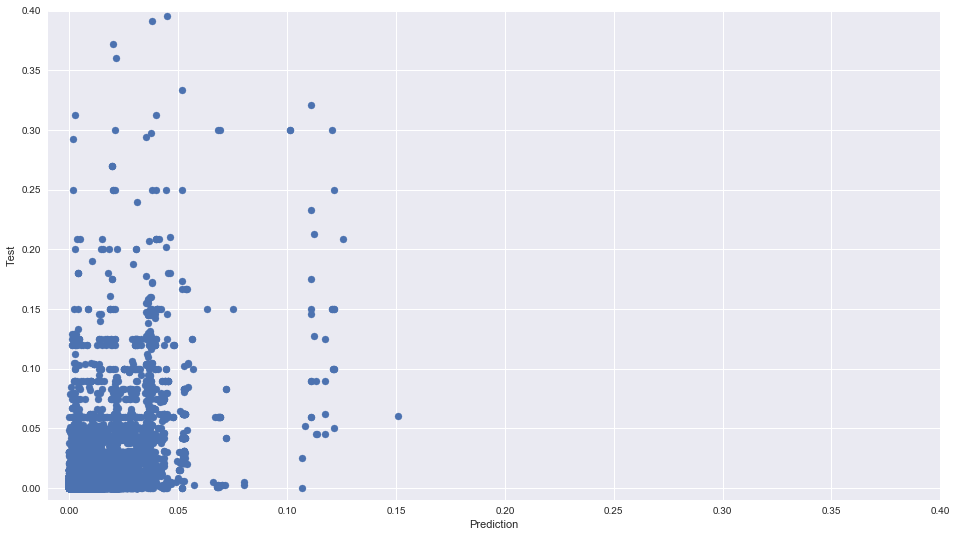

In [95]:
# Plotting Prediction v/s Test Data
plt.scatter(prediction_list,test_list)
plt.xlim(-0.01,0.40)
plt.ylim(-0.01,0.40)
plt.xlabel('Prediction')
plt.ylabel('Test')

In [89]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(algo.pu)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

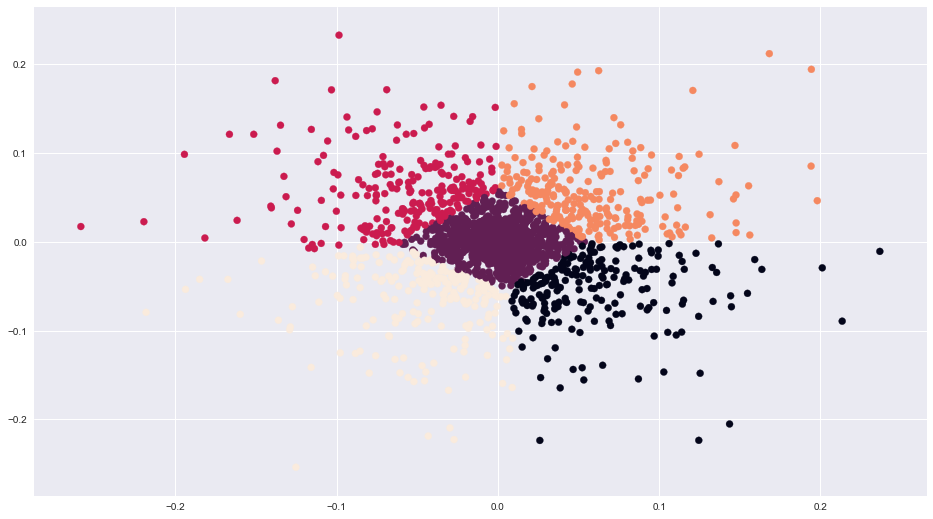

In [90]:
# plotting the users as clusters
plt.scatter(algo.pu[:, 0], algo.pu[:, 1], c=kmeans.labels_)

In [91]:
Users_Y = [y for y in np.where(kmeans.labels_ == 2) ]
Users_X = [x for x in np.where(kmeans.labels_ == 4) ]
counter = []
real_user_x = trainset.to_raw_uid(Users_X[0][0])
set_of_items_real_user = matrix_setup['StockCode'][matrix_setup['CustomerID'] == real_user_x]
set_of_items_real_user = set_of_items_real_user.to_frame()
for i in Users_X[0][1:]:
    neighbor_user_x = trainset.to_raw_uid(i)
    set_of_items_neighbor = matrix_setup['StockCode'][matrix_setup['CustomerID'] == neighbor_user_x]
    set_of_items_neighbor = set_of_items_neighbor.to_frame()
    print (set_of_items_real_user.merge(set_of_items_neighbor)).count()
    counter.append((set_of_items_real_user.merge(set_of_items_neighbor)).count()[0])


    

StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype: int64
StockCode    3
dtype: int64
StockCode    0
dtype: int64
StockCode    0
dtype

In [92]:

user_y_counter = []
for i in Users_Y[0]:
    user_y = trainset.to_raw_uid(i)
    set_of_items_y = matrix_setup['StockCode'][matrix_setup['CustomerID'] == user_y]
    set_of_items_y = set_of_items_y.to_frame()
    #print (set_of_items_real_user.merge(set_of_items_y)).count()
    user_y_counter.append((set_of_items_real_user.merge(set_of_items_y)).count()[0])

In [93]:
#check similar items bought by users of other clusters 
print 'Another Cluster: max intersection of items #',np.array(user_y_counter).max(),' with the first user'
print 'Another Cluster: Total number of intersection of items #',np.array(user_y_counter).sum(),' with the first user'

Another Cluster: max intersection of items # 3  with the first user
Another Cluster: Total number of intersection of items # 6  with the first user


In [94]:
# Keeping first user as our focal point
# check similar items bought by neighbors
print 'Same Cluster: max intersection of items #',np.array(counter).max(),' with the first user'
print 'Same Cluster: Total number of intersection of items #',np.array(counter).sum(),' with the first user'

Same Cluster: max intersection of items # 3  with the first user
Same Cluster: Total number of intersection of items # 9  with the first user
